In [1]:
from glob import glob
import numpy as np 
import pandas as pd 
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
images_paths = []
masks_paths = glob(f'{data_dir}/*/*_mask*')

for i in masks_paths:
    images_paths.append(i.replace('_mask', ''))

df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths}) # 2 columns -> first column has the path to actual images and the 
# second column has the path to its correspoding masked images

Now, there is one more column required in the df dataframe which will be useful for the classification tasks. The required column will have the details if the tumor exists for every sample in the dataframe. To identify that if the tumor exist for a particular sample in the dataframe, we read all the images in the masks_path and convert into pixel values. If the pixel value at any point in an image is greater than 0, then the particular patient has a tumour in his brain.  

In [3]:
def identify_if_tumour_exist(mask_path):
    #identify the maximum value of the image that exist in the masks_path 
    max_pixel = np.max(cv2.imread(mask_path))
    if max_pixel>0:
        return 1 # the image in he particular mask_path has tumor 
    else:
        return 0 # the image in the particular mask_ath does not have tumor

In [4]:
df["mask"] = df["masks_paths"].apply(identify_if_tumour_exist)

In [5]:
df.head(10)

,images_paths,masks_paths,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
5,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
6,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
7,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
8,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
9,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


In [6]:
print(df.dtypes)

images_paths    object
masks_paths     object
mask             int64
dtype: object


In [7]:
df['mask'].value_counts() # out of all patient in the dataframe df, 2556 patients dont have a tumor, while the rest of 1373 patients has a tumor 

0    2556
1    1373
Name: mask, dtype: int64

In [8]:
df = df.astype(str)
print(df.dtypes)

images_paths    object
masks_paths     object
mask            object
dtype: object


In [9]:
# train dev test split for model validation in the later stage 
train, test = train_test_split(df, train_size=0.85)
# val, test = train_test_split(other, test_size=0.3)
df['mask'] = df['mask'].apply(lambda x: str(x)) # to use it readily in flow_from_dataframe 

### Image Augmentation
Image augmentation is a technique of applying different transformations to original images which results in multiple transformed copies of the same image. Each copy, however, is different from the other in certain aspects depending on the augmentation techniques you apply like shifting, rotating, flipping, etc. It lets you augment your images in real-time while your model is still training! You can apply any random transformations on each training image as it is passed to the model

In [10]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='images_paths',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='images_paths',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='images_paths',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


### Deep Convolutional Neural Networks for tumor classification
Now, as the dataset is prepared, the CNN model can be trained on the dataset to classify if the MR Images has tumor in it. This model is a classical example of binary classification problem. The trained CNN model can be tested on the new MR Images (which were not a part of training process such as test data) to predict the presence of tumor from the patients MR Image. For training this classifier, I use the Resnet-50 model which was pretrained in the imagenet dataset.  

In [11]:
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

In [12]:
# setting all the trainable parameters to be true --> all parameters in the network will be trained
for layer in clf_model.layers:
    layer.trainable=True

# Callback feature in Tensorflow
 callbacks are the special utilities or functions that are executed during training at given stages of the training procedure. 
 Callbacks can help you prevent overfitting, visualize training progress, debug your code, save checkpoints, generate logs, create a TensorBoard, etc. 
 important callback --> early stopping 
 This callback is used very often. This allows us to monitor our metrics, and stop model training when it stops improving. 
 For example, assume that you want to stop training if the accuracy is not improving by 0.05; you can use this callback to do so. This is useful in preventing overfitting of a model, to some extent.

In [13]:
# usually when using a pretrained network, the last few layer of network needs to be changed in order for the model to work for our application. In out case
# the model must be able to do binary classification. As a result the final layer of the network needs to be changed. 
from tensorflow.keras.layers import Flatten, AveragePooling2D
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(32, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(64, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.1)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )

In [14]:
early_stop = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )

red_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             ) # This callback is used when you want to change the learning rate when the metrics have stopped improving.
#  it will reduce the learning based on the metric (not epoch).
callbacks = [early_stop, red_lr]

In [15]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 50, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=callbacks)

Epoch 1/50
187/187 [==============================] - 71s 147ms/step - loss: 0.6336 - accuracy: 0.6572 - val_loss: 6.8197 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - 25s 133ms/step - loss: 0.5152 - accuracy: 0.7164 - val_loss: 0.9847 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - 25s 133ms/step - loss: 0.4667 - accuracy: 0.7495 - val_loss: 2.8091 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - 25s 132ms/step - loss: 0.4482 - accuracy: 0.7692 - val_loss: 0.7146 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - 25s 134ms/step - loss: 0.4226 - accuracy: 0.7890 - val_loss: 0.5595 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 6/50
187/187 [==============================] - 25s 134ms/step - loss: 0.4093 - accuracy: 0.7773 - val_loss: 0.4936 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 7/50
187/187 [==============================] 

In [16]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

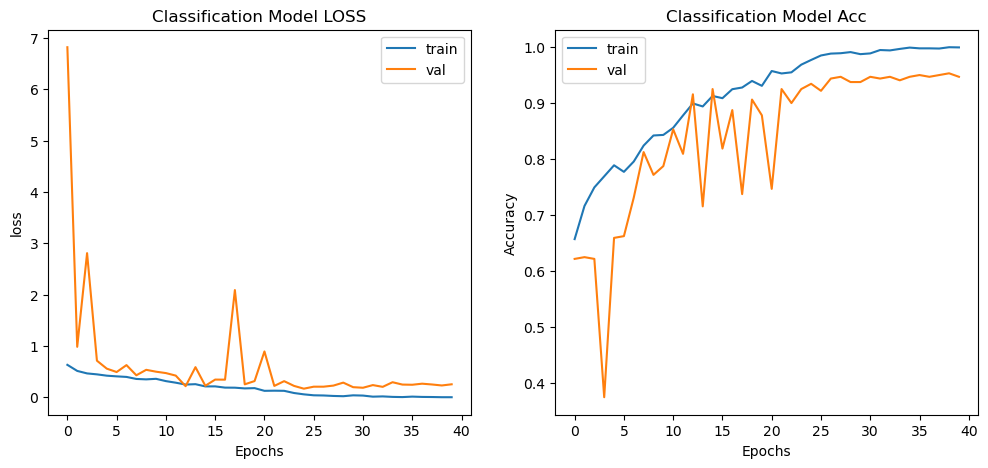

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [18]:
model_json = model.to_json()
with open("res50_classifier.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 61ms/step - loss: 0.2818 - accuracy: 0.9542
Test accuracy : 95.42372822761536 %


In [20]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

37/37 [==============================] - 3s 48ms/step
0.9542372881355933
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       385
           1       0.95      0.91      0.93       205

    accuracy                           0.95       590
   macro avg       0.95      0.94      0.95       590
weighted avg       0.95      0.95      0.95       590



NameError: name 'sns' is not defined

<Figure size 500x500 with 0 Axes>